# Projeto IA - Análise de Imagens Radiográficas

Os  algoritmos  de  Inteligência  Artificial  (IA), particularmente  o  aprendizado  profundo (Deep  Learning),  demonstraram  um  progresso  notável  nas  tarefas  de  reconhecimento  de imagens. Métodos que variam de redes neurais convolucionais a auto-codificadores variacionais encontraram  inúmeras  aplicações  no  campo  da  análise  de  imagens  médicas,  impulsionando  a pesquisa em um ritmo acelerado.Os métodos de IA são excelentes em reconhecer automaticamente padrões complexos nos dados de imagem e fornecer avaliações quantitativas, e não qualitativas, das características radiográficas e podem servir de suporte para os profissionais de saúde.

O objetivo  deste projeto é criar  um  modelo  de  IA  capaz  de  detectar anormalidades em imagens de radiografias de membros do corpo humano.


Fonte dos dados: https://stanfordmlgroup.github.io/competitions/mura/
Fonte do Paper: https://arxiv.org/abs/1712.06957

## 1. Instalação e carga dos pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Comando para silenciar o Keras
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [3]:
# Manipulação do SO
import io
import os
import cv2

# Manipulação de arquivos/pastas
from glob import glob

# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização dos dados
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Keras e Tensorflow
import keras
import tensorflow
import keras.backend as k
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Projeto IA - Análise de Imagens Radiográficas" --iversions

Author: Projeto IA - Análise de Imagens Radiográficas

numpy     : 1.21.5
seaborn   : 0.11.2
matplotlib: 3.5.2
cv2       : 4.7.0
pandas    : 1.4.4
keras     : 2.11.0
tensorflow: 2.11.0



## 2. Carregando imagens e labels

In [5]:
# Caminho para os arquivos do dataset MURA
caminho_dataset = 'dados/MURA-v1.1'

In [6]:
# Carregando a lista de imagens de treino
df_imagens_treino = pd.read_csv(caminho_dataset + '/train_image_paths.csv',
                                header = None,
                                names = ['imagem'],
                                dtype = str)

In [7]:
# Visualiza os dados
df_imagens_treino.head()

,imagem
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [8]:
# Variável para ajuste do caminho para as imagens
caminho_mura = 'dados/'

In [9]:
# Ajustando o caminho para as imagens
df_imagens_treino['imagem'] = caminho_mura + df_imagens_treino['imagem']

In [10]:
# Visualiza o caminho ajustado
df_imagens_treino.head()

,imagem
0,dados/MURA-v1.1/train/XR_SHOULDER/patient00001...
1,dados/MURA-v1.1/train/XR_SHOULDER/patient00001...
2,dados/MURA-v1.1/train/XR_SHOULDER/patient00001...
3,dados/MURA-v1.1/train/XR_SHOULDER/patient00002...
4,dados/MURA-v1.1/train/XR_SHOULDER/patient00002...


In [11]:
# Carregando os labels e caminho das imagens de treino
df_img_labels_treino = pd.read_csv(caminho_dataset + '/train_labeled_studies.csv',
                                   header = None,
                                   names = ['caminho_imagem', 'label'],
                                   dtype = str)

In [12]:
# Ajustando o caminho para as imagens
df_img_labels_treino['caminho_imagem'] = caminho_mura + df_img_labels_treino['caminho_imagem']

In [13]:
# Visualiza os dados
df_img_labels_treino.head()

,caminho_imagem,label
0,dados/MURA-v1.1/train/XR_SHOULDER/patient00001...,1
1,dados/MURA-v1.1/train/XR_SHOULDER/patient00002...,1
2,dados/MURA-v1.1/train/XR_SHOULDER/patient00003...,1
3,dados/MURA-v1.1/train/XR_SHOULDER/patient00004...,1
4,dados/MURA-v1.1/train/XR_SHOULDER/patient00005...,1


In [14]:
# Carregando a lista de imagens de teste
df_imagens_teste = pd.read_csv(caminho_dataset + '/valid_image_paths.csv',
                               header = None,
                               names = ['imagem'],
                               dtype = str)

In [15]:
# Ajustando o caminho para as imagens
df_imagens_teste['imagem'] = caminho_mura + df_imagens_teste['imagem']

In [16]:
# Carregando os labels e caminho das imagens de teste
df_img_labels_teste = pd.read_csv(caminho_dataset + '/valid_labeled_studies.csv',
                                  header = None,
                                  names = ['caminho_imagem', 'label'],
                                  dtype = str)

In [17]:
# Ajustando o caminho para as imagens
df_img_labels_teste['caminho_imagem'] = caminho_mura + df_img_labels_teste['caminho_imagem'] 

In [18]:
# Visualiza
df_img_labels_teste.head()

,caminho_imagem,label
0,dados/MURA-v1.1/valid/XR_WRIST/patient11185/st...,1
1,dados/MURA-v1.1/valid/XR_WRIST/patient11186/st...,1
2,dados/MURA-v1.1/valid/XR_WRIST/patient11186/st...,1
3,dados/MURA-v1.1/valid/XR_WRIST/patient11186/st...,1
4,dados/MURA-v1.1/valid/XR_WRIST/patient11187/st...,1


## 3. Analisando os dados e Engenharia de Atributos

In [19]:
# Shape das imagens de treino
df_imagens_treino.shape

(36808, 1)

In [20]:
# Shape labels de treino
df_img_labels_treino.shape

(13457, 2)

In [21]:
# Proporção de labels por classe
df_img_labels_treino['label'].value_counts()

0    8280
1    5177
Name: label, dtype: int64

In [22]:
# Shape imagens de teste
df_imagens_teste.shape

(3197, 1)

In [23]:
# Shape labels de teste
df_img_labels_teste.shape

(1199, 2)

In [24]:
# Verifica o caminho completo de uma imagem de exemplo
df_img_labels_treino['caminho_imagem'][0]

'dados/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/'

In [25]:
# Ajustando as colunas dos dados de treino com o membro do corpo
df_img_labels_treino['membro'] = df_img_labels_treino['caminho_imagem'].apply(lambda x: str(x.split('/')[3])[3:])

In [26]:
# Visualiza o resultado
df_img_labels_treino.head()

,caminho_imagem,label,membro
0,dados/MURA-v1.1/train/XR_SHOULDER/patient00001...,1,SHOULDER
1,dados/MURA-v1.1/train/XR_SHOULDER/patient00002...,1,SHOULDER
2,dados/MURA-v1.1/train/XR_SHOULDER/patient00003...,1,SHOULDER
3,dados/MURA-v1.1/train/XR_SHOULDER/patient00004...,1,SHOULDER
4,dados/MURA-v1.1/train/XR_SHOULDER/patient00005...,1,SHOULDER


In [27]:
# Ajustando as colunas de dados de treino com o número do paciente
df_img_labels_treino['num_paciente'] = df_img_labels_treino['caminho_imagem'].apply(lambda x: str(x.split('/')[4]))

In [28]:
# Visualiza o resultado
df_img_labels_treino.head()

,caminho_imagem,label,membro,num_paciente
0,dados/MURA-v1.1/train/XR_SHOULDER/patient00001...,1,SHOULDER,patient00001
1,dados/MURA-v1.1/train/XR_SHOULDER/patient00002...,1,SHOULDER,patient00002
2,dados/MURA-v1.1/train/XR_SHOULDER/patient00003...,1,SHOULDER,patient00003
3,dados/MURA-v1.1/train/XR_SHOULDER/patient00004...,1,SHOULDER,patient00004
4,dados/MURA-v1.1/train/XR_SHOULDER/patient00005...,1,SHOULDER,patient00005


In [29]:
# Ajustando as colunas de dados de treino com o número do estudo
df_img_labels_treino['num_estudo'] = df_img_labels_treino['caminho_imagem'].apply(lambda x: str(x.split('/')[5])[:6])

In [30]:
# Visualiza o resultado
df_img_labels_treino.head()

,caminho_imagem,label,membro,num_paciente,num_estudo
0,dados/MURA-v1.1/train/XR_SHOULDER/patient00001...,1,SHOULDER,patient00001,study1
1,dados/MURA-v1.1/train/XR_SHOULDER/patient00002...,1,SHOULDER,patient00002,study1
2,dados/MURA-v1.1/train/XR_SHOULDER/patient00003...,1,SHOULDER,patient00003,study1
3,dados/MURA-v1.1/train/XR_SHOULDER/patient00004...,1,SHOULDER,patient00004,study1
4,dados/MURA-v1.1/train/XR_SHOULDER/patient00005...,1,SHOULDER,patient00005,study1


In [31]:
# Mesmo o processo nos dados de teste
df_img_labels_teste['membro'] = df_img_labels_teste['caminho_imagem'].apply(lambda x: str(x.split('/')[3])[3:])
df_img_labels_teste['num_paciente'] = df_img_labels_teste['caminho_imagem'].apply(lambda x: str(x.split('/')[4]))
df_img_labels_teste['num_estudo'] = df_img_labels_teste['caminho_imagem'].apply(lambda x: str(x.split('/')[5])[:6])
df_img_labels_teste['num_caso'] = df_img_labels_teste[['num_paciente', 'num_estudo']].apply(lambda x: ''.join(x), 
                                                                                            axis = 1)

In [32]:
# Visualiza o resultado
df_img_labels_teste.head()

,caminho_imagem,label,membro,num_paciente,num_estudo,num_caso
0,dados/MURA-v1.1/valid/XR_WRIST/patient11185/st...,1,WRIST,patient11185,study1,patient11185study1
1,dados/MURA-v1.1/valid/XR_WRIST/patient11186/st...,1,WRIST,patient11186,study1,patient11186study1
2,dados/MURA-v1.1/valid/XR_WRIST/patient11186/st...,1,WRIST,patient11186,study2,patient11186study2
3,dados/MURA-v1.1/valid/XR_WRIST/patient11186/st...,1,WRIST,patient11186,study3,patient11186study3
4,dados/MURA-v1.1/valid/XR_WRIST/patient11187/st...,1,WRIST,patient11187,study1,patient11187study1


## 4. Análise Exploratória

### 1) Qual o número de pacientes únicos?

In [33]:
# Número único de pacientes em treino
len(df_img_labels_treino['num_paciente'].unique())

11184

In [34]:
# Número único de pacientes em teste
len(df_img_labels_teste['num_paciente'].unique())

783

### 2) Qual a proporção de registros por classe?

<AxesSubplot:title={'center':'Balanceamento de Classe em Treino'}, xlabel='label', ylabel='count'>

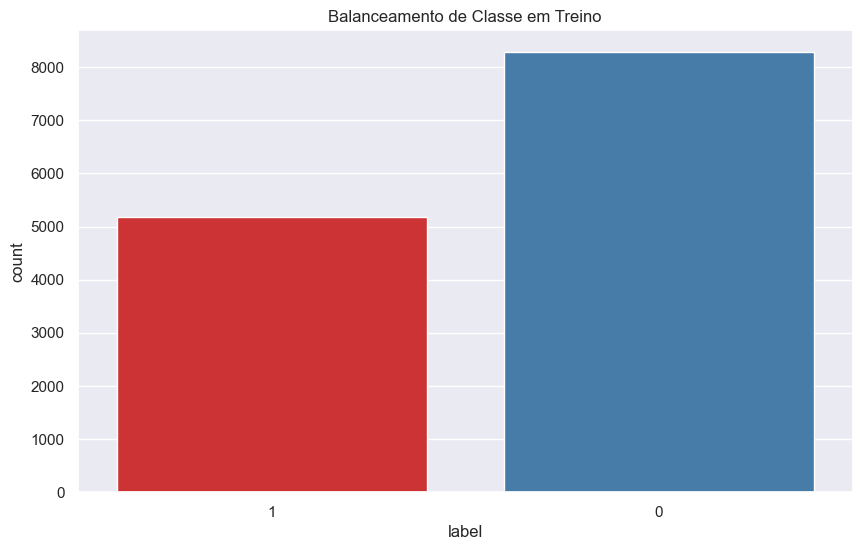

In [35]:
# Plot do Balanceamento de Classe em Treino
plt.figure(figsize = (10,6))
sns.set(style = "darkgrid")
plt.title('Balanceamento de Classe em Treino')
sns.countplot(x = df_img_labels_treino['label'], palette = "Set1")

<AxesSubplot:title={'center':'Balanceamento de Classe em Teste'}, xlabel='label', ylabel='count'>

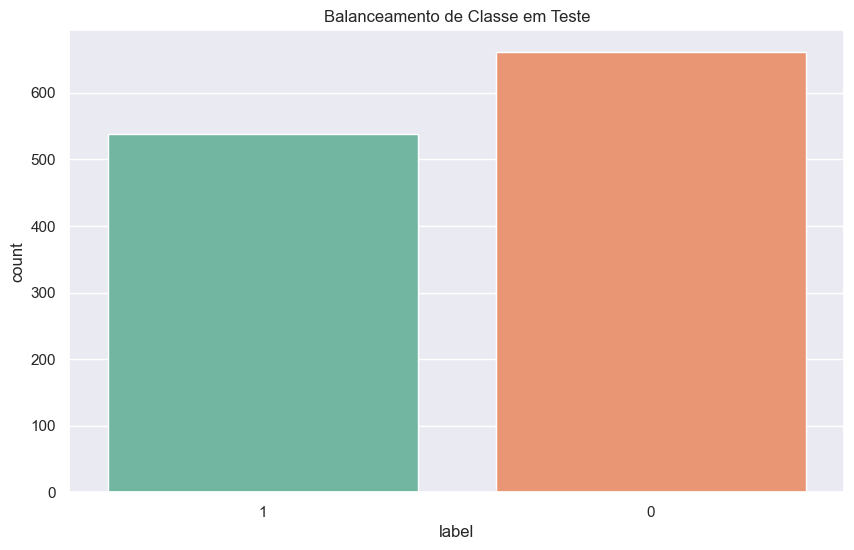

In [36]:
# Plot do Balanceamento de Classe em Teste
plt.figure(figsize = (10,6))
sns.set(style = "darkgrid")
plt.title('Balanceamento de Classe em Teste')
sns.countplot(x = df_img_labels_teste['label'], palette = "Set2")

### 3) Qual a proporção de registros por classe e por membro do corpo humano?

<AxesSubplot:title={'center':'Balanceamento de Classe Por Membro do Corpo em Treino'}, xlabel='membro', ylabel='count'>

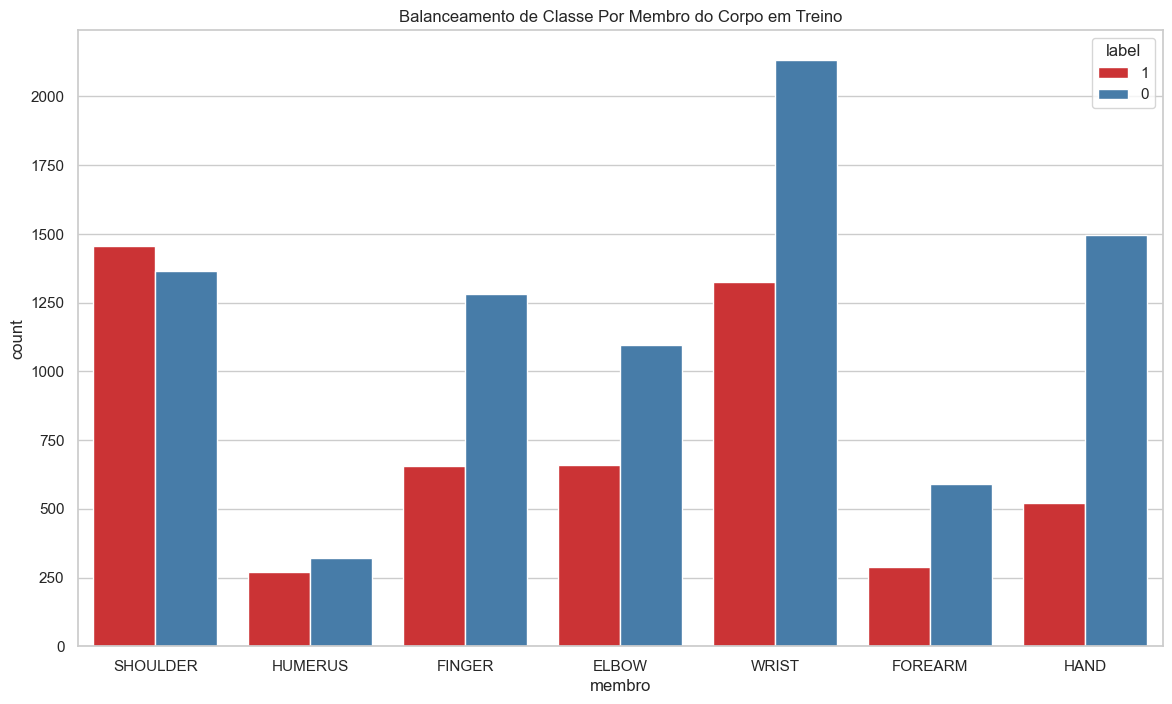

In [37]:
# Plot do Balanceamento de Classe Por Membro do Corpo em Treino
plt.figure(figsize = (14,8))
sns.set_style("whitegrid")
plt.title('Balanceamento de Classe Por Membro do Corpo em Treino')
sns.countplot(data = df_img_labels_treino, x = 'membro', hue = 'label', palette = "Set1")

<AxesSubplot:title={'center':'Balanceamento de Classe Por Membro do Corpo em Teste'}, xlabel='membro', ylabel='count'>

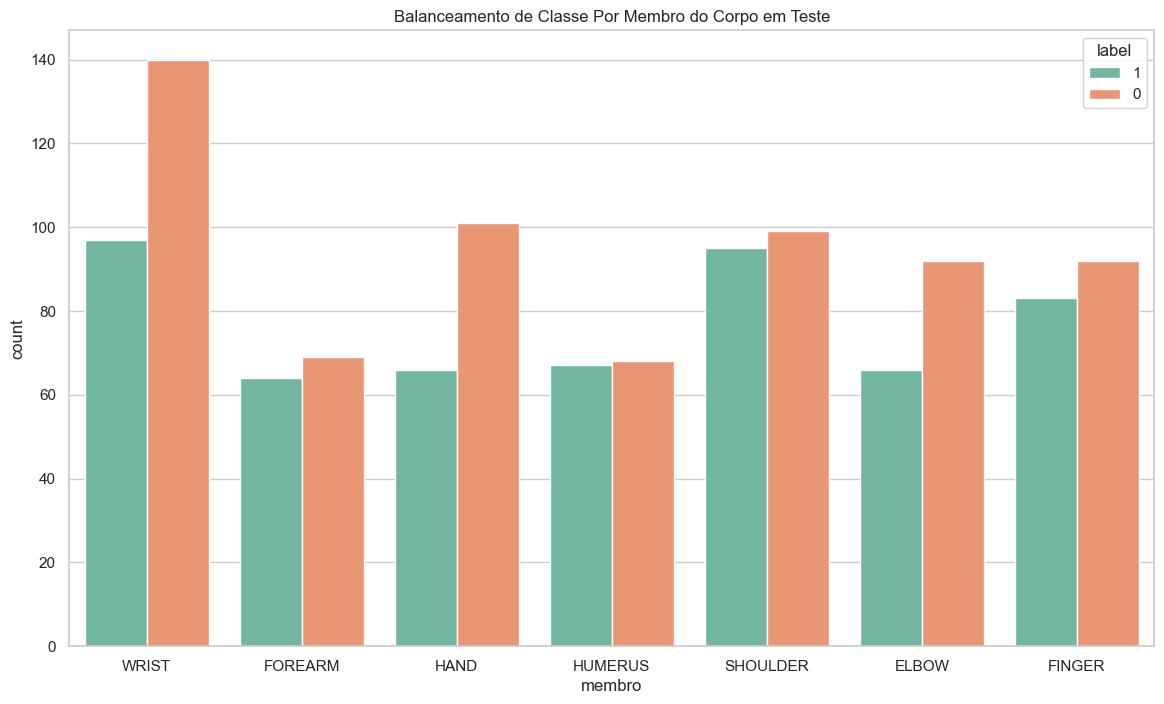

In [38]:
# Plot do Balanceamento de Classe Por Membro do Corpo em Teste
plt.figure(figsize = (14,8))
sns.set_style("whitegrid")
plt.title('Balanceamento de Classe Por Membro do Corpo em Teste')
sns.countplot(data = df_img_labels_teste, x = 'membro', hue = 'label', palette = "Set2")

### 4) Qual a proporação de registros por estudo?

<AxesSubplot:title={'center':'Balanceamento de Classe Por Estudo em Treino'}, xlabel='num_estudo', ylabel='count'>

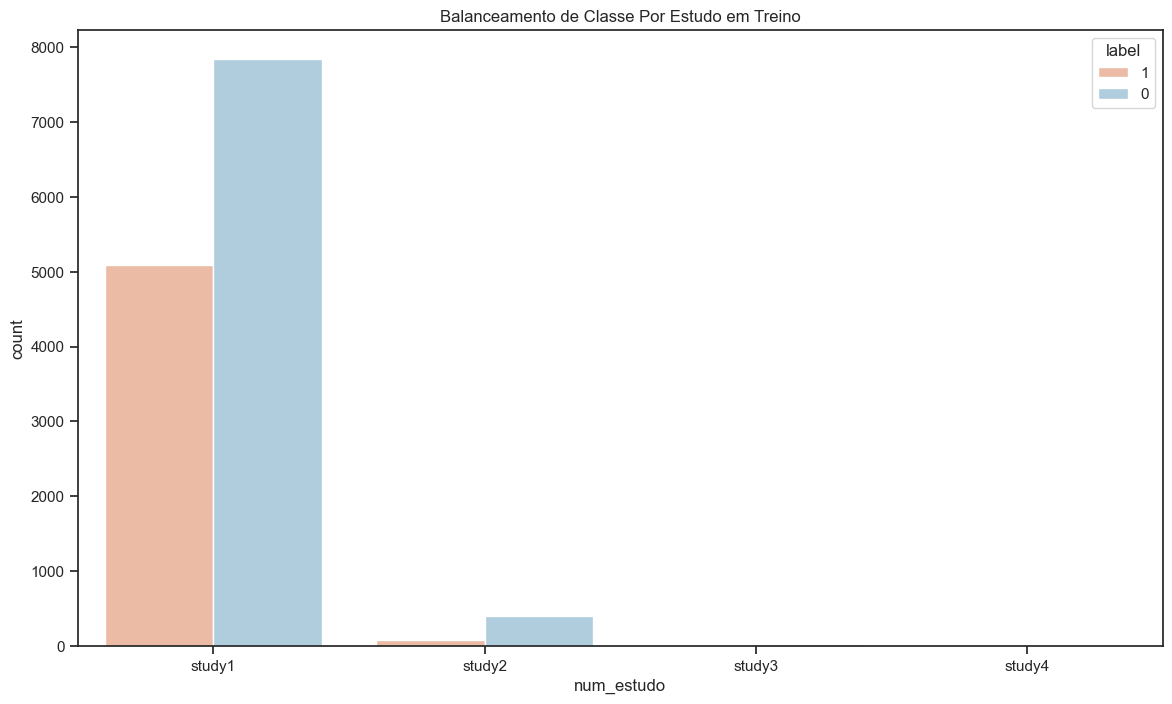

In [39]:
# Plot do Balanceamento de Classe Por Estudo em Treino
plt.figure(figsize = (14,8))
sns.set_style("ticks")
plt.title('Balanceamento de Classe Por Estudo em Treino')
sns.countplot(data = df_img_labels_treino, x = 'num_estudo', hue = 'label', palette = 'RdBu')

<AxesSubplot:title={'center':'Balanceamento de Classe Por Estudo em Teste'}, xlabel='num_estudo', ylabel='count'>

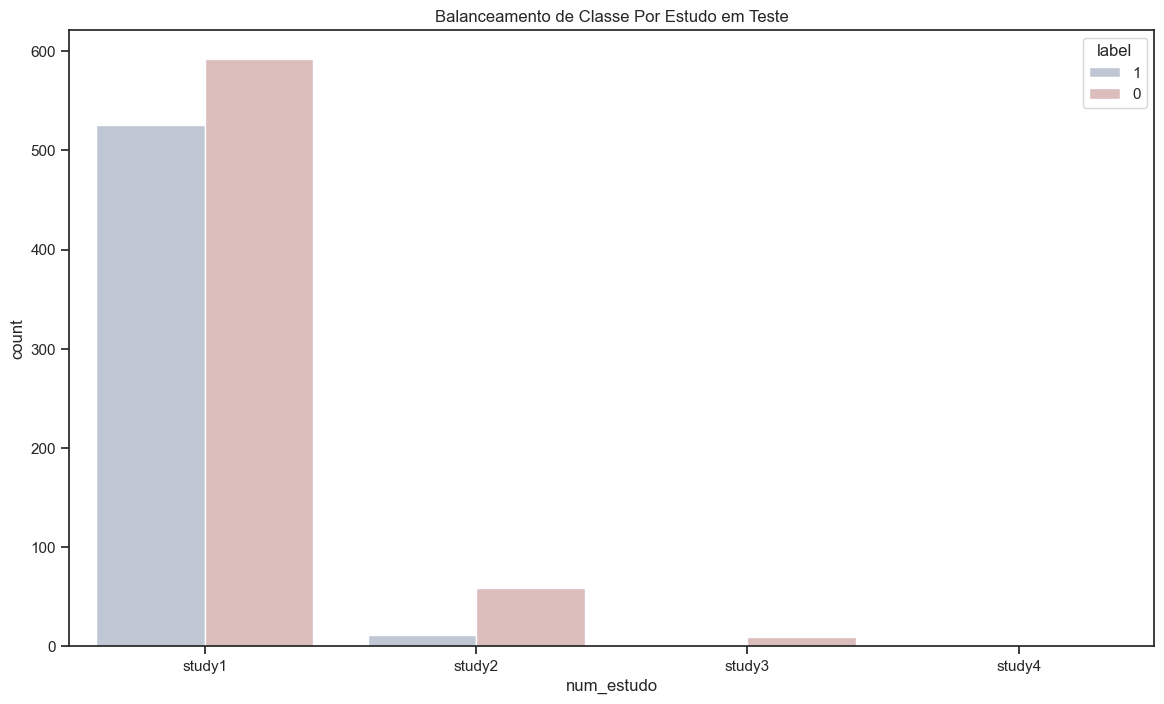

In [40]:
# Plot do Balanceamento de Classe Por Estudo em Teste
plt.figure(figsize = (14,8))
sns.set_style("ticks")
plt.title('Balanceamento de Classe Por Estudo em Teste')
sns.countplot(data = df_img_labels_teste, x = 'num_estudo', hue = 'label', palette = 'vlag')

### 5) Qual o número de imagens de cada membro do corpo humano?

In [41]:
# Engenharia de atributos no dataset de imagens
df_imagens_treino['membro'] = df_imagens_treino['imagem'].apply(lambda x: str(x.split('/')[3])[3:])
df_imagens_treino['num_paciente'] = df_imagens_treino['imagem'].apply(lambda x: str(x.split('/')[4]))
df_imagens_treino['num_estudo'] = df_imagens_treino['imagem'].apply(lambda x: str(x.split('/')[5])[:6])
df_imagens_treino['num_caso'] = df_imagens_treino[['num_paciente', 'num_estudo']].apply(lambda x: ''.join(x), axis = 1)

In [42]:
df_imagens_treino['membro'].value_counts()

WRIST       9752
SHOULDER    8379
HAND        5543
FINGER      5106
ELBOW       4931
FOREARM     1825
HUMERUS     1272
Name: membro, dtype: int64

<AxesSubplot:title={'center':'Número de Imagens de Cada Membro do Corpo nos Dados de Treino'}, xlabel='membro', ylabel='count'>

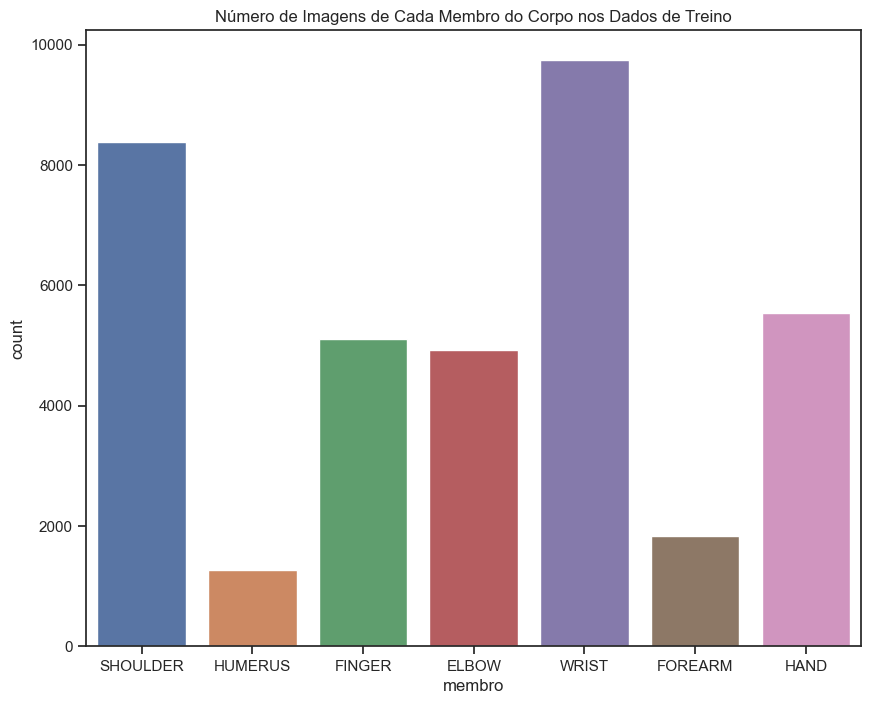

In [43]:
# Plot - Resposta da pergunta 5 de forma visual
plt.figure(figsize = (10,8))
plt.title('Número de Imagens de Cada Membro do Corpo nos Dados de Treino')
sns.countplot(data = df_imagens_treino, x = 'membro', palette = "deep")

In [44]:
# Aplicando o mesmo processo aos dados de teste
df_imagens_teste['membro'] = df_imagens_teste['imagem'].apply(lambda x: str(x.split('/')[3])[3:])
df_imagens_teste['num_paciente'] = df_imagens_teste['imagem'].apply(lambda x: str(x.split('/')[4]))
df_imagens_teste['num_estudo'] = df_imagens_teste['imagem'].apply(lambda x: str(x.split('/')[5])[:6])
df_imagens_teste['num_caso'] = df_imagens_teste[['num_paciente', 'num_estudo']].apply(lambda x: ''.join(x), axis = 1)

In [45]:
# Visualiza
df_imagens_teste.head()

,imagem,membro,num_paciente,num_estudo,num_caso
0,dados/MURA-v1.1/valid/XR_WRIST/patient11185/st...,WRIST,patient11185,study1,patient11185study1
1,dados/MURA-v1.1/valid/XR_WRIST/patient11185/st...,WRIST,patient11185,study1,patient11185study1
2,dados/MURA-v1.1/valid/XR_WRIST/patient11185/st...,WRIST,patient11185,study1,patient11185study1
3,dados/MURA-v1.1/valid/XR_WRIST/patient11185/st...,WRIST,patient11185,study1,patient11185study1
4,dados/MURA-v1.1/valid/XR_WRIST/patient11186/st...,WRIST,patient11186,study1,patient11186study1


In [46]:
# Resposta da pergunta 5
df_imagens_teste['membro'].value_counts()

WRIST       659
SHOULDER    563
ELBOW       465
FINGER      461
HAND        460
FOREARM     301
HUMERUS     288
Name: membro, dtype: int64

<AxesSubplot:title={'center':'Número de Imagens de Cada Membro do Corpo nos Dados de Teste'}, xlabel='membro', ylabel='count'>

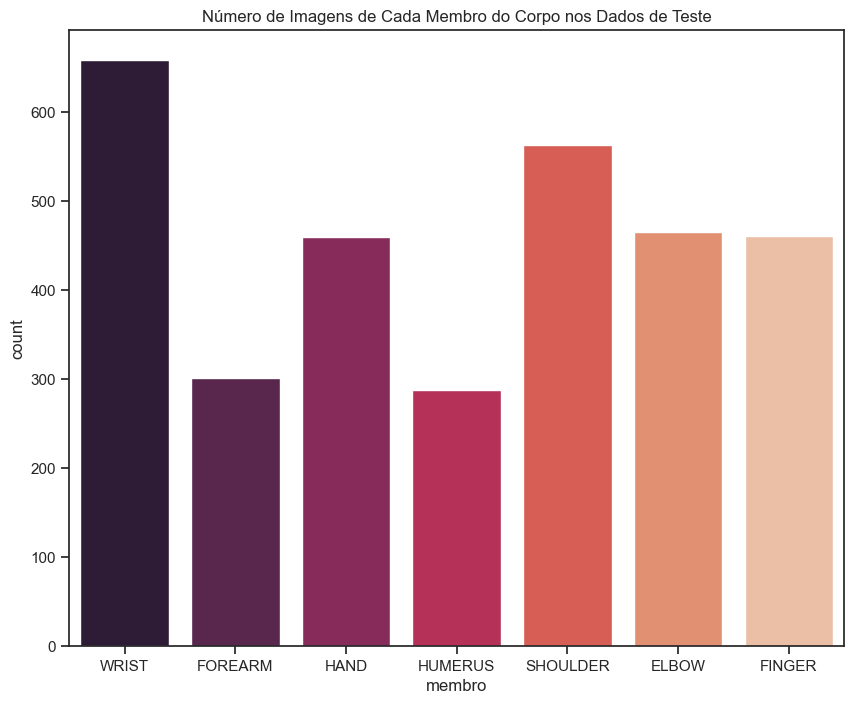

In [47]:
# Plot - Resposta da pergunta 5 de forma visual
plt.figure(figsize = (10,8))
plt.title('Número de Imagens de Cada Membro do Corpo nos Dados de Teste')
sns.countplot(data = df_imagens_teste, x = 'membro', palette = "rocket")

## 5. Pré-Processamento dos Dados

Vamos trabalhar somente com as imagens do pulso (WRIST), pois esse membro é o que apresenta o maior volume de dados. Isso é opcional e você pode criar um único modelo para as imagens de todos os membros ou criar modelos diferentes para cada membro.

Tarefas:

    1. Redimensionamento das imagens com a mesma resolução (usaremos 1 canal).
    2. Normalização das imagens.
    3. Associação dos rótulos a cada imagem.

In [49]:
# Extração dos registros para WRIST em treino
df_treino_img_WRIST = df_imagens_treino[df_imagens_treino['membro'] == 'WRIST']
df_treino_label_WRIST = df_img_labels_treino[df_img_labels_treino['membro'] == 'WRIST']

In [50]:
# Extração dos registros para WRIST em teste
df_teste_img_WRIST = df_imagens_teste[df_imagens_teste['membro'] == 'WRIST']
df_teste_label_WRIST = df_img_labels_teste[df_img_labels_teste['membro'] == 'WRIST']

In [51]:
# Função para redimensionar e normalizar as imagens
def resize_img(Path):
    
    # Leitura da imagem
    img = cv2.imread(Path)
    
    # Usaremos dimensões 150x150
    img = cv2.resize(img,(150,150))
    
    # Converte para array Numpy
    img = np.array(img)
    
    return img

In [52]:
# Dicionário de treino
dict_treino = {}

In [54]:
# Loop
for i in df_treino_label_WRIST.index:
    
    # Obtém caminho da imagem e label
    folder = df_treino_label_WRIST['caminho_imagem'].loc[i]
    labels = df_treino_label_WRIST['label'].loc[i]
    
    # Arquivos com extensão .png
    pic = glob(folder + '*.png')
    
    # Para cada imagem, aplica o resize e grava o resultado
    for filename in pic:
        dict_treino[filename] = labels
        im = resize_img(filename)
        cv2.imwrite(filename, im)

In [55]:
# Verifica o resultado
dict_treino

{'dados/MURA-v1.1/train/XR_WRIST/patient06359/study1_positive\\image1.png': '1',
 'dados/MURA-v1.1/train/XR_WRIST/patient06359/study1_positive\\image2.png': '1',
 'dados/MURA-v1.1/train/XR_WRIST/patient06360/study1_positive\\image1.png': '1',
 'dados/MURA-v1.1/train/XR_WRIST/patient06360/study1_positive\\image2.png': '1',
 'dados/MURA-v1.1/train/XR_WRIST/patient06360/study1_positive\\image3.png': '1',
 'dados/MURA-v1.1/train/XR_WRIST/patient06360/study1_positive\\image4.png': '1',
 'dados/MURA-v1.1/train/XR_WRIST/patient06361/study1_positive\\image1.png': '1',
 'dados/MURA-v1.1/train/XR_WRIST/patient06361/study1_positive\\image2.png': '1',
 'dados/MURA-v1.1/train/XR_WRIST/patient06361/study1_positive\\image3.png': '1',
 'dados/MURA-v1.1/train/XR_WRIST/patient06362/study1_positive\\image1.png': '1',
 'dados/MURA-v1.1/train/XR_WRIST/patient06362/study1_positive\\image2.png': '1',
 'dados/MURA-v1.1/train/XR_WRIST/patient06362/study1_positive\\image3.png': '1',
 'dados/MURA-v1.1/train/XR_W

In [56]:
# Converte o dicionário em um dataframe
df_treino_WRIST = pd.DataFrame()
df_treino_WRIST['imagem'] = dict_treino.keys()
df_treino_WRIST['label'] = dict_treino.values()

In [57]:
# Total de registros
df_treino_WRIST.count()

imagem    9752
label     9752
dtype: int64

In [58]:
# Visualiza
df_treino_WRIST.head()

,imagem,label
0,dados/MURA-v1.1/train/XR_WRIST/patient06359/st...,1
1,dados/MURA-v1.1/train/XR_WRIST/patient06359/st...,1
2,dados/MURA-v1.1/train/XR_WRIST/patient06360/st...,1
3,dados/MURA-v1.1/train/XR_WRIST/patient06360/st...,1
4,dados/MURA-v1.1/train/XR_WRIST/patient06360/st...,1


In [59]:
# Repetimos a operação para os dados de teste

# Dicionário
dict_teste = {}

# Loop
for i in df_teste_label_WRIST.index:
    folder = df_teste_label_WRIST['caminho_imagem'].loc[i]
    labels = df_teste_label_WRIST['label'].loc[i]
    pic = glob(folder + '*.png')
    for filename in pic:
        dict_teste[filename] = labels
        im = resize_img(filename)       
        cv2.imwrite(filename, im)  

In [61]:
# Convertemos o dicionário para dataframe
df_teste_WRIST = pd.DataFrame()
df_teste_WRIST['caminho_imagem'] = dict_teste.keys()
df_teste_WRIST['label'] = dict_teste.values()

In [62]:
# Resultado
df_teste_WRIST.count()

caminho_imagem    659
label             659
dtype: int64

## 6. Arquitetura do modelo

LeNet é uma das primeiras redes neurais convolucionais (CNN) e tem sido fundamental para o desenvolvimento de Deep Learning. Foi proposta por Yann LeCun para reconhecimento de dígitos manuscritos. A arquitetura LeNet-5, especificamente, é bastante conhecida e referenciada frequentemente.

Aqui está uma descrição detalhada da arquitetura LeNet-5:

**Camada de Entrada (Input Layer)**: Recebe as imagens de entrada.

**Camada Convolucional 1**: Esta camada tem o kernel (filtro) de tamanho 3x3 ou 5x5, resultando em mapas de características (devido à convolução). Esta camada detecta diferentes características de baixo nível, como bordas, nas imagens de entrada.

**Camada de Subamostragem/Pooling 1**: Esta camada segue a camada convolucional e realiza a operação de pooling, especificamente o max pooling, sobre os mapas de características. O tamanho do kernel de pooling é 2x2 com um stride de 2, o que efetivamente reduz a dimensão dos mapas de características pela metade..

**Camada Convolucional 2**: Esta camada tem o kernel (filtro) de tamanho 3x3 ou 5x5, resultando em mapas de características. O kernel aqui é capaz de detectar um número maior de características de alto nível.

**Camada de Subamostragem/Pooling 2**: Esta camada realiza a operação de max pooling nos mapas de características, reduzindo a dimensão da matriz de dados.

**Camada Convolucional 3**: Nesta etapa, em vez de produzir um mapa de características, cada kernel produz um único valor através da convolução com a região 3x3 na entrada. Isso resulta em valores, que podem ser tratados como um vetor de características para classificação. Esta camada pode ou não ser seguida de outra camada de Pooling.

**Camada Totalmente Conectada**: Essa camada lineariza o vetor de características da camada anterior antes da classificação final.

**Camada de Saída (Output Layer)**: Esta é uma camada que classifica a imagem de entrada nas classes correspondentes. Normalmente aplica função softmax ou sigmóide.

A rede LeNet é um exemplo clássico de uma rede neural convolucional. A arquitetura básica de convolução seguida por subamostragem é um padrão que é ainda amplamente usado em redes neurais mais modernas e complexas.

### 61. Construção do modelo

In [63]:
# Define o input_shape
input_shape = (150,150,3)

In [64]:
# Define o kernel de convolução
kernel = (3,3)

In [68]:
# Construção do modelo com Keras

# Sequência de camadas
modelo_v1 = Sequential()

# Primeira camada convolucional
modelo_v1.add(Conv2D(32, kernel, input_shape = input_shape))
modelo_v1.add(Activation('relu'))
modelo_v1.add(MaxPooling2D(pool_size = (2,2)))

# Segunda camada convolucional
modelo_v1.add(Conv2D(32, kernel))
modelo_v1.add(Activation('relu'))
modelo_v1.add(MaxPooling2D(pool_size = (2,2)))

# Terceira camada convolucional
modelo_v1.add(Conv2D(64, kernel))
modelo_v1.add(Activation('relu'))
modelo_v1.add(MaxPooling2D(pool_size = (2,2)))

# Camada totalmente conectada
modelo_v1.add(Flatten())
modelo_v1.add(Dense(64))
modelo_v1.add(Activation('relu'))
modelo_v1.add(Dropout(0.5))

# Camada de saída
modelo_v1.add(Dense(1, activation = 'sigmoid'))

In [69]:
# Compilação do modelo
modelo_v1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc', 'mse'])

In [70]:
# Sumário do modelo
modelo_v1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                  

### 6.2 Dataset augmentation

In [71]:
# Gerador de imagens sintéticas - Usamos em dados de treino
datagen = ImageDataGenerator(horizontal_flip = True,
                             vertical_flip = True,
                             rescale = 1./255,
                             rotation_range = 25,
                             fill_mode = 'nearest',)

In [72]:
# Normalização de imagens - Usamos em dados de teste
datagen1 = ImageDataGenerator(rescale = 1./255,)

In [73]:
# Hiperparâmetros
image_size = (150, 150)
batch_size = 32
epochs = 50

In [74]:
# Gera os dados de treino
train_generator = datagen.flow_from_dataframe(df_treino_WRIST,
                                              x_col = 'imagem',
                                              y_col = 'label',
                                              target_size = image_size,
                                              class_mode = 'binary',
                                              batch_size = batch_size)

Found 9752 validated image filenames belonging to 2 classes.


In [75]:
# Gera os dados de teste
test_generator = datagen1.flow_from_dataframe(df_teste_WRIST,
                                              x_col = 'caminho_imagem',
                                              y_col = 'label',
                                              target_size = image_size,
                                              class_mode = 'binary',
                                              batch_size = batch_size)

Found 659 validated image filenames belonging to 2 classes.


In [76]:
# Define o tamanho das amostras
sample_size_treino = df_treino_WRIST['label'].count()
sample_size_teste = df_teste_WRIST['label'].count()

## 7. Treino do modelo

In [77]:
%%time
modelo_v1_history = modelo_v1.fit_generator(train_generator, 
                                            steps_per_epoch = sample_size_treino // batch_size,    
                                            epochs = epochs, 
                                            validation_data = test_generator, 
                                            validation_steps = sample_size_teste // batch_size )

Epoch 1/50
304/304 [==============================] - 157s 514ms/step - loss: 0.6526 - acc: 0.6075 - mse: 0.2307 - val_loss: 0.6603 - val_acc: 0.5922 - val_mse: 0.2341
Epoch 2/50
304/304 [==============================] - 94s 310ms/step - loss: 0.6323 - acc: 0.6361 - mse: 0.2209 - val_loss: 0.6539 - val_acc: 0.6156 - val_mse: 0.2313
Epoch 3/50
304/304 [==============================] - 95s 312ms/step - loss: 0.6248 - acc: 0.6472 - mse: 0.2177 - val_loss: 0.6478 - val_acc: 0.6078 - val_mse: 0.2288
Epoch 4/50
304/304 [==============================] - 113s 371ms/step - loss: 0.6182 - acc: 0.6537 - mse: 0.2153 - val_loss: 0.6356 - val_acc: 0.6062 - val_mse: 0.2236
Epoch 5/50
304/304 [==============================] - 114s 374ms/step - loss: 0.6152 - acc: 0.6549 - mse: 0.2136 - val_loss: 0.6434 - val_acc: 0.6266 - val_mse: 0.2255
Epoch 6/50
304/304 [==============================] - 103s 339ms/step - loss: 0.6128 - acc: 0.6622 - mse: 0.2125 - val_loss: 0.6323 - val_acc: 0.6297 - val_mse: 0

304/304 [==============================] - 111s 365ms/step - loss: 0.4821 - acc: 0.7675 - mse: 0.1569 - val_loss: 0.5498 - val_acc: 0.7422 - val_mse: 0.1793
Epoch 50/50
304/304 [==============================] - 103s 337ms/step - loss: 0.4740 - acc: 0.7716 - mse: 0.1556 - val_loss: 0.5247 - val_acc: 0.7469 - val_mse: 0.1732
Wall time: 1h 33min 8s


## 8. Avaliação do modelo

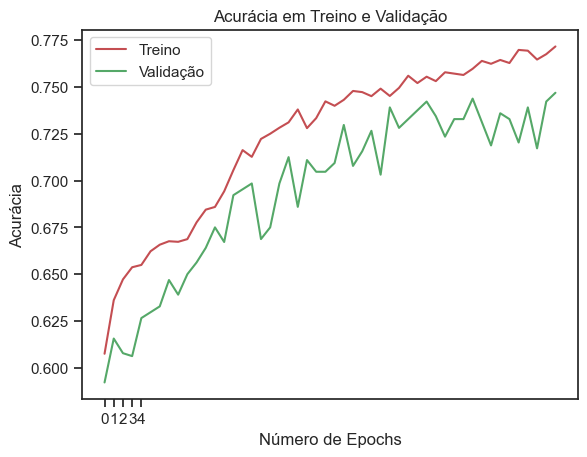

In [78]:
# Plot da Acurácia 
plt.figure(0)
plt.plot(modelo_v1_history.history['acc'],'r')
plt.plot(modelo_v1_history.history['val_acc'],'g')
plt.xticks(np.arange(0, 5, 1))
plt.rcParams['figure.figsize'] = (10, 8)
plt.xlabel("Número de Epochs")
plt.ylabel("Acurácia")
plt.title("Acurácia em Treino e Validação")
plt.legend(['Treino', 'Validação'])
plt.show()

A linha de acurácia em treino está com tendência de alta, o que é esperado do modelo. Porém, a linha do dataset de validação está instável, o que pode indicar que o número de passadas em cada rodada do treino precisa aumentar.

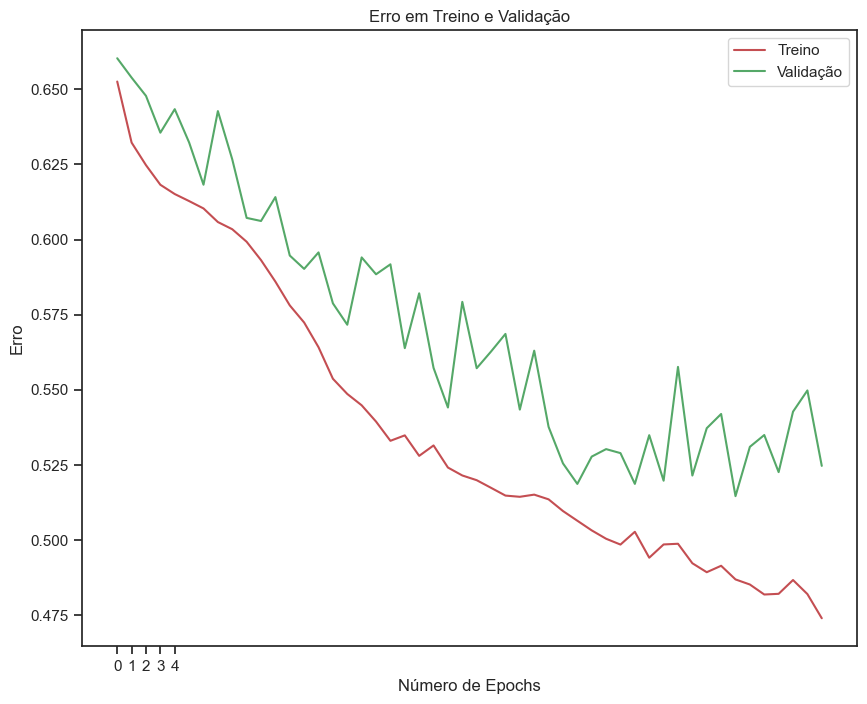

In [79]:
# Plot do Erro
plt.figure(1)
plt.plot(modelo_v1_history.history['loss'],'r')
plt.plot(modelo_v1_history.history['val_loss'],'g')
plt.xticks(np.arange(0, 5, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Número de Epochs")
plt.ylabel("Erro")
plt.title("Erro em Treino e Validação")
plt.legend(['Treino', 'Validação'])
plt.show()

A linha de acurácia em treino está com tendência de baixa, o que é esperado do modelo. Porém, a linha do dataset de validação está instável, o que pode indicar que o número de passadas em cada rodada do treino precisa aumentar.

In [80]:
# Salvando o modelo em disco
from keras.models import load_model

# Salva o modelo
modelo_v1.save('modelos/modelo_v1.h5')  

# Carrega o modelo
modelo_v1 = load_model('modelos/modelo_v1.h5')

In [81]:
# Avaliação e Teste do modelo
aval_v1 = modelo_v1.evaluate_generator(test_generator, 
                                       steps = (sample_size_teste // batch_size) + 1, 
                                       workers = 0,
                                       use_multiprocessing = False)

In [82]:
# Acurácia do modelo em dados de teste
aval_v1[1]

0.7496206164360046

A performance de 75% é ótima, levando em consideração que tivemos poucas épocas de treino e poucas passadas. 
Existe espaço para melhor ainda mais o modelo.